In [5]:
!pip install split-folders tqdm
!pip install -U -q kaggle
!apt install pv
!pip install -U -q PyDrive

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  doc-base
The following NEW packages will be installed:
  pv
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 48.3 kB of archives.
After this operation, 123 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 pv amd64 1.6.6-1 [48.3 kB]
Fetched 48.3 kB in 1s (87.6 kB/s)
Selecting previously unselected package pv.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import splitfolders
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the dataset and split it into test train and eval sets

Upload your Kaggle Json API key

In [ ]:
files.upload()

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 659M/675M [00:09<00:00, 86.2MB/s]
100% 675M/675M [00:10<00:00, 70.0MB/s]


In [10]:
!unzip -o /content/cell-images-for-detecting-malaria.zip| pv -l >/dev/null
os.remove('cell-images-for-detecting-malaria.zip')

55.1k 0:00:09 [5.79k/s] [          <=>                                         ]


In [11]:
splitfolders.ratio("/content/cell_images/cell_images", output="/content/cell_images/cell_images_split", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 27560 files [00:04, 6642.27 files/s]


## Generate the model using TensorFlow & Keras

In [12]:
base_model=MobileNet(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) ]
preds=Dense(2,activation='softmax')(x) 

17227776/17225924 [==============================] - 0s 0us/step


In [13]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [19]:
train_datagen= ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('/content/cell_images/cell_images_split/train',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', shuffle=True)


model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
hist = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=20)

Found 22046 images belonging to 2 classes.
Epoch 1/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0937 - accuracy: 0.9680
Epoch 2/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0868 - accuracy: 0.9683
Epoch 3/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0730 - accuracy: 0.9731
Epoch 4/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0634 - accuracy: 0.9772
Epoch 5/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0592 - accuracy: 0.9784
Epoch 6/20
688/688 [==============================] - 59s 85ms/step - loss: 0.0479 - accuracy: 0.9825
Epoch 7/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0428 - accuracy: 0.9845
Epoch 8/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0366 - accuracy: 0.9871
Epoch 9/20
688/688 [==============================] - 59s 86ms/step - loss: 0.0332 - accuracy: 0.9881
Epoch 10/20
688/688 [==================

## Saving the Model

In [20]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1bWNEm5QXiCwpZHXXkU2ZCvFNfJaGU0cH'})

## Evaluating the model

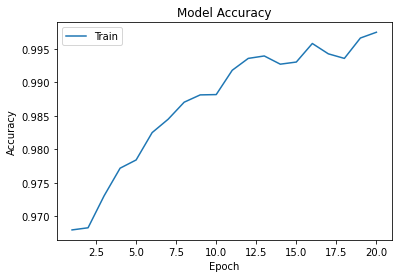

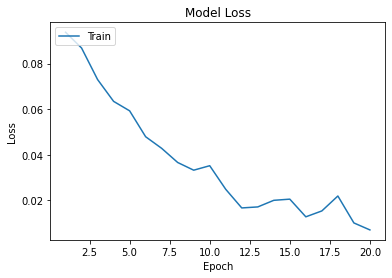

In [29]:
def plotLearningCurve(hist,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,hist.history['accuracy'])
 
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train'],loc='upper left')
  plt.show()

  plt.plot(epochRange,hist.history['loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train'],loc='upper left')
  plt.show()

plotLearningCurve(hist,20)